In [1]:
import random
import numpy as np  
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.utils import Sequence

from keras.models import load_model, model_from_json
from keras.preprocessing import text
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras import backend as K
from keras import optimizers

import time
import datetime
import re
from scipy import spatial
from subprocess import Popen, PIPE, STDOUT
from difflib import SequenceMatcher
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

pd.options.display.max_colwidth = 200
%matplotlib inline

/home/dolmstead/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
region_dict = {0: "albuquerque", 1: "billings", 2: "calgary", 3: "charlotte", 4: "chicago", 5: "cincinnati", 6: "denver", 
               7: "houston", 8: "kansas city", 9: "las vegas", 10: "los angeles", 11: "minneapolis", 12: "montreal", 
               13: "nashville", 14: "new york", 15: "oklahoma city", 16: "phoenix", 17: "pittsburgh", 18: "san francisco", 
               19: "seattle", 20: "tampa", 21: "toronto", 22: "washington"}
range_to_region = {0: 3, 1: 4, 2: 5, 3: 7, 4: 10, 5: 13, 6: 14, 7: 15, 8: 18, 9: 19, 10: 20, 11: 21, 12: 22}
region_to_range = {3: 0, 4: 1, 5: 2, 7: 3, 10: 4, 13: 5, 14: 6, 15: 7, 18: 8, 19: 9, 20: 10, 21: 11, 22: 12}
region_ids = [3,  4,  5,  7, 10, 13, 14, 15, 18, 19, 20, 21, 22]
df = pd.read_csv('data/tweets_labelled_balanced.csv', nrows=300000)
df.dropna(inplace=True)
df.region = df.region.astype(int)
df['text'] = df['text'].apply(lambda x:x.lower())
X = df['text'].tolist()
X2 = ["<s> "+x+" <e>" for x in X]
X3 = [x+" <e>" for x in X]
y = df['region'].tolist()
region_ids = np.unique(y)

# Set Parameters
training_ratio = .75
training_size = int(len(X)*training_ratio)
num_classes = 23
target_num_words = 10000
H = 500
epochs = 100
batch_size = 48
learning_rate = .0001
embedding_vector_length = 200

# Encode strings
t = text.Tokenizer(num_words=target_num_words, lower=True, char_level=False, filters='')

# Convert strings to sequences, pad them to uniform length, and divide up training and test sets
t.fit_on_texts(X2)
word_index = t.word_index
V = target_num_words + 2 #len(word_index)+1
index_word = {v: k for k, v in t.word_index.items()}
X_seq = t.texts_to_sequences(X)
X2_seq = t.texts_to_sequences(X2)
X3_seq = t.texts_to_sequences(X3)
x_length = max(len(x) for x in X2_seq)
X_padded = sequence.pad_sequences(X_seq, maxlen=x_length, padding='post')
X2_padded = sequence.pad_sequences(X2_seq, maxlen=x_length, padding='post')
X3_padded = sequence.pad_sequences(X3_seq, maxlen=x_length, padding='post')

X_train = X_padded[:training_size]
X2_train = X2_padded[:training_size]
X3_train = X3_padded[:training_size]
X_test = X_padded[training_size:]
X2_test = X2_padded[training_size:]
X3_test = X3_padded[training_size:]
y_train = y[:training_size]
y_test = y[training_size:]

## Load the Model

In [3]:
# Load Trained Model
from keras.models import load_model, model_from_json

model_name = 'Twitter_500k10k_1BLx2L_6drop'

model_weights = model_name+"_weights"
encoder_name = model_name+"_encoder"
decoder_name = model_name+"_decoder"
encoder_weights = encoder_name+"_weights"
decoder_weights = decoder_name+"_weights"

def load_model_weights(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

model = load_model_weights('models/{}.json'.format(model_name), 'models/{}.h5'.format(model_weights))
encoder_model = load_model_weights('models/{}.json'.format(encoder_name), 'models/{}.h5'.format(encoder_weights))
decoder_model = load_model_weights('models/{}.json'.format(decoder_name), 'models/{}.h5'.format(decoder_weights))

## Load Naive Bayes Model for Validation

In [4]:
NB_X_train, NB_X_test, NB_y_train, NB_y_test = train_test_split(X, y, test_size=0.25, random_state=42)

vec = CountVectorizer()
train_vocab = vec.fit_transform(NB_X_train)
test_vocab = vec.transform(NB_X_test)

a = 0.5
mnb = MultinomialNB(alpha=a)
mnb.fit(train_vocab, NB_y_train)
mnb_predicted_labels = mnb.predict(test_vocab)
mnb_f1 = metrics.f1_score(NB_y_test, mnb_predicted_labels, average='weighted', labels=np.unique(mnb_predicted_labels))
mnb_acc = metrics.accuracy_score(NB_y_test, mnb_predicted_labels)

print("F1 score for alpha={}: {:.4f}, accuracy: {:.2f}% ".format(a, mnb_f1, mnb_acc*100))

F1 score for alpha=0.5: 0.2197, accuracy: 21.85% 


In [5]:
def get_nb_prediction(t, target=False):
    t = [t] if type(t) is not list else t
    vec_tweet = vec.transform(t)
    mnb_probs = mnb.predict_proba(vec_tweet)
    if target:
        return mnb_probs[:,region_to_range[target]] 
    else:
        predictions = mnb.predict(vec_tweet).reshape(1, len(t))
        probs = np.array([max(x) for x in mnb_probs]).reshape(1, len(t))
        return np.r_[predictions, probs]
    
tweet_list = ["if you're looking for work in va, check out this #job: #hiring #careerarc", 
              "i'm at cassell’s burgers in los angeles, ca",
              "go seahawks!",
              "dude i have a startup.  want to invest in electric scooters?"]

get_nb_prediction(tweet_list)

array([[22.        , 10.        , 19.        , 18.        ],
       [ 0.81499308,  0.999192  ,  0.45192878,  0.49598021]])

## Test This Model

## Evaluate Encoder Classifier

In [6]:
def get_lstm_prediction(source, target=False):
    ''' Given a sequence, get its predicted region and loss.'''
    if type(source) == str:
        source = t.texts_to_sequences([source])
    layer_dict = dict([(layer.name, layer) for layer in encoder_model.layers])
    model_input = encoder_model.input
    model_output = layer_dict['encoder_dense'].output
    get_output = K.function([model_input], [model_output])
    results = get_output([source])[0]
    if target:
        return results[:,target]
    else:
        predictions = []
        probs = []
        for a in results:
            region = np.argmax(a)
            predictions.append(region)
            probs.append(a[region])
        return np.column_stack(([predictions, probs])).T

    
sample = X_padded[[2,3]]
get_lstm_prediction(sample)

array([[22.        ,  7.        ],
       [ 0.84665   ,  0.10326579]])

In [8]:
indices = [random.randint(training_size, len(X)) for x in range(1000)]
tweets = np.array(X)[[indices]]
samples = X_padded[[indices]]
labels = np.array(y)[indices]
predictions = get_lstm_prediction(samples)
nb_predictions = get_nb_prediction(list(tweets))
d = {'tweets': tweets, 'labels': labels, 'lstm_pred': predictions[0].astype(int), 'lstm_certainty': predictions[1], 
     'nb_predictions': nb_predictions[0].astype(int), 'nb_certainty': nb_predictions[1]}
df_classtest = pd.DataFrame(data=d)
df_classtest[:10]

,tweets,labels,lstm_pred,lstm_certainty,nb_predictions,nb_certainty
0,"agree, but they will try!",22,19,0.214092,19,0.134396
1,"happy thanksgiving!! spend time with your family’s today, love one another, and appreciate the time you have with them !",15,5,0.133591,5,0.281872
2,well i found out that i can drink hennessey again.. my tolerance is coming back bitches😜,20,18,0.155262,7,0.198860
3,who has two thumbs and talks all the customers ears off? this gal👍,20,15,0.150044,21,0.370965
4,"we updated our window display and i’m so excited, i love the new november look!",19,15,0.114793,14,0.770205
5,"robbie has such a huge family and the holiday’s are literally here, and ya homegirl is terrified to meet all these new people especially the most important person in his life 🙃#anxietyproblems",21,18,0.168220,19,0.480007
6,"want to work in #bethesda, md? view our latest opening: #accounting #job #jobs #hiring #careerarc",22,22,0.919398,22,0.997972
7,"i'm at starbucks in schererville, in",4,5,0.121584,14,0.126685
8,i wish you could go live on twitter .,13,15,0.146190,7,0.127025
9,can’t wait to see the saints drop 51 on the cowboys,20,15,0.417457,15,0.506017


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec3d0ce630>]],
      dtype=object)

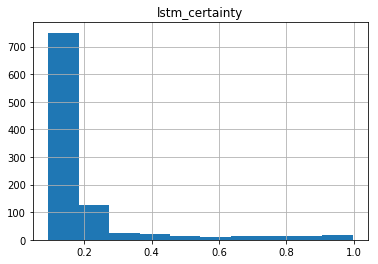

In [8]:
#300k tweets
df_classtest.hist(column='lstm_certainty', bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff344706da0>]],
      dtype=object)

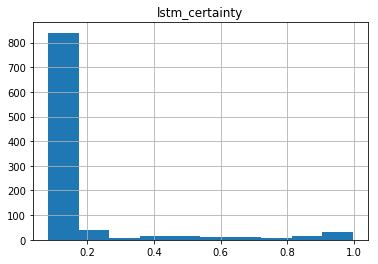

In [10]:
#1m tweets
df_classtest.hist(column='lstm_certainty', bins=10)

Text(0.5,0.98,'Naive Bayes')

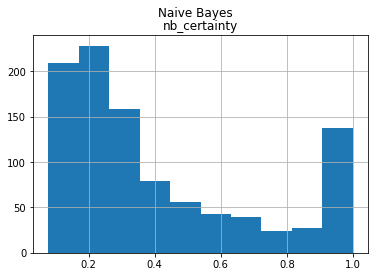

In [10]:
import pylab as pl
df_classtest.hist(column='nb_certainty', bins=10)
pl.suptitle("Naive Bayes")

In [9]:
lstm_score = 0
nb_score = 0
concurrence = 0
for x in range(len(labels)):
    lstm_score += 1 if predictions[0][x] == labels[x] else 0
    nb_score += 1 if nb_predictions[0][x] == labels[x] else 0
    concurrence += 1 if nb_predictions[0][x] == predictions[0][x] else 0

print("LSTM Accuracy: {:.2f}% \nNB Accuracy: {:.2f}% \nConcurrence {:.2f}%"
      .format((lstm_score/len(labels))*100, (nb_score/len(labels))*100, (concurrence/len(labels))*100))

LSTM Accuracy: 17.80% 
NB Accuracy: 33.00% 
Concurrence 27.30%


### Evaluate Encoder/Decoder

In [11]:
# Quick spot-check the fidelity of the model (ie, that inputs/outputs match)
fidelity = check_fidelity_batch(X_test, 100)
fidelity[0][:10]

,Source,Decoded,Fidelity
0,coming from the biggest liar on earth define clear,coming from the biggest liar on earth cannot determine,0.953604
1,as knows he’s about to start playing he thinks he can hit me with there any new episodes u can 🙄,as nobody seems about to start playing he says he can give me with other another series anyone about we 🙄,0.795963
2,drunk leaving ..,drunk leaving ..,1.000000
3,this high i am feeling is,this high i am feeling is,1.000000
4,fuck nudes send me pics of your dogs,fuck nudes send me pics of your dogs,1.000000
5,what was your birthday wish 🎂 . may you find happiness and in your all your personal photos at,what was your birthday wish may . upon you find happiness and in your all personal new media at,0.892899
6,just gone get me a little bottle and 😌,just gone get me a little bottle and 😌,1.000000
7,i agree with this there is no better place for solar than california. start here -&gt;,i agree with this there is no better place for climate change. here’s start here -&gt;,0.934623
8,what’s his ig lmaoo,what’s his ig lmaoo,1.000000
9,everyday 😆,everyday 😆,1.000000


In [12]:
fidelity[1]

0.9601730424165725

### Evaluate Translator

In [11]:
# Spot-check a random tweet
ran = random.randint(0, len(X))
print("index: ", ran)
translate(X_padded[[ran]], target=10, probs=True)

index:  56055


('are you seriously trying to lecture someone on how to spend this is at best. a country with no border is not a country. come here legally or don’t come at all. build the #maga #usa',
 '(seattle, 11.54%)',
 'are you seriously trying to bring yourself on you to find this is a college a near with no they live in election tomorrow. is people can afford them at tax states to bare health. ???',
 '(seattle, 13.08%)')

In [62]:
# Batch-check the translation quality
pd.options.display.max_colwidth = 200
translate_batch(X_test[[100, 101]], target=10, num=2, probs=True)

ValueError: could not convert string to float: 'i wanna cry so bad, i wanna cry so bad'

In [16]:
# 300k 1Bix1L
source = 'does anyone care that california is burning?'
source_pad = get_padded_sequence([source])[0]
predicted_region = get_lstm_prediction(source_pad)
print("Source tweet: {} ({}, {:.2f}%)".format(source, region_dict[predicted_region[0][0]], predicted_region[1][0]))
for x in region_ids:
    this_translation = translate(source_pad, target=x, probs=True)
    print("{}".format(this_translation[2]))

Source tweet: does anyone care that california is burning? (san francisco, 0.14%)
does recommend everybody that is or racist.
does anyone care that california is foh
does anyone care that california is trash.
does care once that here is plate
does anyone care that california is #ncte18
does anyone care that is california pathetic.
does anyone care that is purchased #dogsofinstagram
does anyone care that california is pathetic.
does anyone care that california is #hiring
does anyone care that california is water.
does anyone care that california is #disney
does anyone care that california is trash.
does care whatever that california is involved.


In [ ]:
# 1m Tweet Set:
'''
Source tweet: this season especially, the packers fans have zero room to talk shit about the bears or vikings. (cincinnati, 0.29%)
charlotte: this season the packers fans have technical talk to put weird about the chiefs or (cincinnati, 22.42%)
chicago: this season the jets ive have shown room to talk shit about the bears or (cincinnati, 15.47%)
cincinnati: this season the packers sports have been cincinnati talk to talk about the tiger or (cincinnati, 70.87%)
houston: this entire the fsu had these played mad kid to sleep about real the other (tampa, 59.34%)
los angeles: this scorpio the wizards commercials have chicago rooms done to talk shit the other and (chicago, 27.03%)
nashville: this season the redskins tigers have every training ass to talk about the bears or (washington, 26.77%)
new york: this season the #steelers #design have zero chicago to talk about his or bears to (chicago, 67.74%)
oklahoma city: this season the steelers kings have yourself every room makes shit to talk ya! or (cincinnati, 11.85%)
san francisco: this the past draymond (i have performing him jump to talk about the or tho (san francisco, 9.20%)
seattle: this season the packers fans have beers beauty driver to talk about the #pnw lounge (seattle, 72.99%)
tampa: this season the friendsgiving you'll have zero room to talk shit about the goodness (los angeles, 10.27%)
toronto: this season the matchup benefit have pittsburgh beauty and not talk about the guts (new york, 19.54%)
washington: this morning! the bengals tonight! have class working dog to shit about tiger or the (cincinnati, 54.54%)
'''

#300k 1Bix1L Set
'''
Source tweet: this season especially, the packers fans have zero room to talk shit about the bears or vikings. (chicago, 0.55%)
charlotte: this season the panthers have gone sports room to talk shit about the bears or (charlotte, 38.55%)
chicago: this season the packers have zero room to talk fans about it the bears or anymore. (chicago, 87.67%)
cincinnati: this season the rams fans have happened to talk shit before the white team. (charlotte, 20.70%)
houston: this season the titans watched dallas have everything talk shit to throw about or not (oklahoma city, 68.40%)
los angeles: this season fans the rams have gone to talk shit about the kiss the white (charlotte, 26.56%)
nashville: this season the rams have the tv fans talk shit about to throw like (charlotte, 20.84%)
new york: this season fans the rams pub have to grill game about the fucking house. white (charlotte, 20.68%)
oklahoma city: this season the chiefs fans have flipped the talk about it loud to kill there (oklahoma city, 22.33%)
san francisco: this season the packers have we’re starting some noise talk about the paradise bears or (chicago, 36.68%)
seattle: this crowd the fans have zero coming to rocky movies. the people want a hill (nashville, 14.25%)
tampa: this season the football have during the let’s talk shit about to throw the white (charlotte, 18.60%)
toronto: this season the fans have puck scream outside to talk about the foul kill or (seattle, 26.88%)
washington: this season the packers fans have hours to talk shit about the fear kill wh (charlotte, 18.24%)
'''

### Run the test set on this model

In [13]:
# Run this model on a standardized test bed of tweets
test_set = {3: ['not true. but i hear you',
  'thursday isn’t coming fast enough i’m ready to eat',
  'awful first quarter again for the still can’t play a lick of defense and i don’t see the hustle i want to from these young players. no reason you should be tired this early.',
  'compare trump manufacturing numbers to kindly sit down. also return your prize for and step right up for a prize in',
  "why you should train like a if you're a | - if you're a your swim training might look very different than a competitive coach lindsey that shouldn't be the case.",
  'if only we had that espn cam',
  'the comments on this unc g ucla feed 😂😂😂😂',
  'with the sc on our chest',
  '➡️ for the 44 yard tech 7 ii georgia 28',
  "we're #hiring! read about our latest #job opening here: registered nurse - #rn sc"],
 4: ['is all about show and nothing about',
  'we are so thankful for everyone’s donations so far and we hope to gather even more food items for this holiday season. see salon for more details on how to earn a…',
  'well i would have never that! what was her favorite film of mine is probably the file on he was also with in sorry wrong number. i also liked it when bob made him into a in holiday',
  'temperature up -&gt; down -&gt; 7mph -&gt; 5mph',
  'a hint in the book of love to only one person never works out. in any and all the devil sees and the devil and justin are already married and enjoys the game of love',
  'at - drinking a vanilla porter by @ lake brewing company —',
  "i liked him, too. he just couldn't get right. had some great too. was the best (not for under but getting rid of greg might have been the worst bears move i've seen.",
  'crazy as this still sits in my mind how i supposedly gave a ring to someone just to shut her up. mind you i did it in if that was the case i done it here in illinois and not spent so much money to do it.',
  'i’m a fan of the chicago version of board game myself.',
  'can you recommend anyone for this #job in il? #nursing #hiring #careerarc'],
 5: ['made this for &amp; hope they like it',
  'being than you are literally at when it comes to knee space smh.',
  'one taught me love taught me one taught me pain',
  'i’m so thankful to have parents who are the greatest examples of love and they truly make an effort to love on everyone that their',
  'does anyone else’s heart drop at the sound of the garage door opening after you’ve done nothing all day? like oh shoot i have 20 seconds to get off my phone and look productive before my mom comes in',
  'if only notre dame could figure out how to a cowboys uniform and a bulls uniform into their fit for today’s game they’d complete the lame 90s fan',
  'may we all experience this joy at the end. is sweet, sad, but not - - @ indiana',
  'one could argue that no one brings more to a and therefore money to its football which turns into money for the school, which turns into money for a state than a head college football coach does.',
  'interested in a #job in #indianapolis, in? this could be a great fit: #hiring #careerarc',
  "big game. big implications. i'm picking #4 michigan to beat #10 ohio state in who you got? #goblue"],
 7: ['you want more you want free',
  'son, i had no idea i was paying for',
  'i’ll park how i want, if you got a problem call the call the gonna try me but y’all won’t break me.',
  'was gonna have a friendsgiving but into it so i’m just gonna sleep all day instead',
  'one of my coworkers said me to me and when i tell you i charged at this bitch 😂😂😂😂 thank u for grabbing me and putting me in the back n now the girl quit anyways bc she didn’t wanna work w me',
  "ain't gonna bum no money for you she ain't like that.. but she can put you on she scares the shit out of me.",
  'you want to be figure out how to keep big from going to austin or',
  'am trying to find a movie theatre in austin, texas area &amp; not',
  'my momma some serious mf went from letting me do what i want to tryna stop it , baby once u say it , ain’t no coming back from it sis ! so',
  'just posted a photo @ san antonio, texas'],
 10: ['she’s in love \U0001f970 with and',
  'not trying to scare you off friend',
  'there’s been a mass shooting. shut up about your stupid charger for 5 minutes.',
  'car got broken into i cannot trust street parking in la',
  'someone come and watch bohemian rhapsody with heard nothing but good things about that movie 🎥',
  'dear hollywood please give the roles of paul lindsey collins &amp; in this one scene from she proved she can channel all of them without a',
  'i haven’t been to santa monica in over a year. that used to be my spot 😩',
  'all i want for my birthday is for you to vote for me in the broadway world la i’m nominated for featured actress in a play - local for mr.',
  'last night this guy said i looked like jordan and i laughed and he’s like seriously you do, i know her im a in beverly i said hook it up then 😭😂',
  'san ca thu nov 8th am forecast: today sunny hi tonight clear'],
 13: ['you can tell a lot by a',
  'this is kicking my ass. hope i can hit the doctor instead of the',
  'god - ft. (official music video) via',
  'thank god. some people don’t need on having class. i married an eastern european for that reason.',
  'and it’s 7 bra i’m bout to gts',
  'the edited karma album on apple music didn’t get edited bruh',
  'atlanta we got another chance at a championship. in our @',
  'nashville to become home of east coast of \r\n',
  'finished nashville and now i don’t know what to watch 😕',
  'interested in a #job in #huntsville, al? this could be a great fit: #microsoft #hiring #careerarc'],
 14: ['day by starting to understand the',
  'i voted for on stream music from apple music',
  'two of our lady tucker and james will be signing their on thursday at at',
  'get these vegan castle this sunday at ’s vegan sunday. we’ll have some of your other favorites on the menu too.',
  'throw back last #turkey @ pennsylvania',
  'ceo of sustainable energy for all rachel the new of global energy and “the energy systems are going to be very different in the she said, and',
  'accident in on us 23 nb at #traffic',
  'accident in on pkwy nb at',
  'mark your - #givingtuesday is nov just 1 week from today! please join me in helping make boston the urban population by supporting my run with \r\n\r\n',
  "i'm at - station in nj"],
 15: ['should i call u ? 🤔',
  "let's go out for a drink",
  'watching for the time just to see my boo mr.',
  'a 5th round pick should have had the luxury of 3 or 4 years on the practice no 5th round pick gets thrown to the wolves like this kid was. i wish him great luck , he’s a class act',
  'cowboys with red - soon to be a mini clutch 😍 i’ve been this forever 😂',
  "want to work at we're #hiring in tx! click for details: #marketing #job #jobs",
  'i cast my heisman ballot for #tuatagovailoa! click the player you think deserves the heisman house vote. (📍)',
  "we're #hiring! click to apply: database admin i - #it #houston, tx #job #jobs #careerarc",
  'our #clerical team is hiring at in #tulsa, ok! click the link to learn more today #job #hiring #careerarc',
  'can you recommend anyone for this #job? director of retail operations - #supplychain #dallas, tx #hiring'],
 18: ['he was as good as not as strong, but had more',
  'the christmas playlist is fire i’m thinking about getting a tree wow',
  ', and gunna killing all the features this',
  'my uber just dropped me off a block away and drove right past me while sticking a middle finger smfh',
  "people bring national artist here often. but it's like even if and when you open for that's it. theres no conversations theres no email exchange theres not even social media exchange something that could equal opportunity down the road.",
  'whose air and other announced it raised $20 million in series b funding on nov',
  'can you recommend anyone for this #job in ca? #psjhjobs',
  "press members are setting up in for #trump to arrive here at air force military wasn't able to if president trump would be answering questions on the #campfire or if he'd simply land to then board a",
  'want to work in ca? view our latest opening: #hospitality #job #jobs #hiring #careerarc',
  "we're #hiring! click to apply: special education teacher and hard of hearing - #education #reno, nv #job #jobs #careerarc"],
 19: ['don’t there are more of us 😂',
  "if you're interested in a blog about the clothes on you can find them at",
  'in 3 weeks, i’m gonna be back on the west side with my all time favorite people who i haven’t seen in months &amp; i couldn’t be more excited @ washington',
  "want to work at match we're #hiring in on! click for details: #marketing #job #jobs #careerarc",
  'anniversary spotlight 9 years of music place great songs from year year seven &amp; fourth - to - tears of pleasure -',
  'i always called them sweet pants cuz i wear them to go down a block for my donut fix',
  '💞 gives a great big “thank you” to for us in better serving our 💋 sexual wellness and education is our #1 priority at',
  'vote! (@ king county administration building in seattle,',
  'not feeling the rain but mom says i’ll be happy i wore it after our walk #pnw',
  'unwanted person at block of sw 12th ave, portland, or [portland police #pdx911'],
 20: ['&amp; and old is not enough',
  'i just turned on fox and whose face do i see and greg how can you say you respect you turned into a bigger asshole than before.',
  'yep, the democratic firing squad has as',
  'sounds like a weird cookie handling issue. wonder if trying another would help?',
  'leaving any doubt about how crooked everyone in trump’s inner circle is: former trump lawyer michael cohen guilty to lying to in deal with mueller',
  'evil democrats steal elections by encouraging many, many people to vote and then have audacity to make sure their votes are',
  'in florida on holiday from the uk was up most of the night reading woke up 2 hours ago praying i’d wake to find that fucking oh the joy of being in your country to watch it happen. home tomorrow so hurry up please. 😀',
  "want to work at kelly services? we're #hiring in #orlando, fl! click for details: #kellyjobs #kellyservices #clerical #job #jobs #careerarc",
  'happy 90th birthday mickey mouse !',
  'andrew gillum let’s bring this home! #florida #miami'],
 21: ["if you're wondering they are last video",
  'are we screwed on the over yet?',
  '2018 beauty monthly all products are &amp; have a mix of full sized',
  "5 game winning streak for thanks to tom wilson it makes this team alot better the way they're playing this season. they may have lot some good players from injuries but no worries they'll make their return soon stay focus and be aggressive by all means",
  "we're #hiring! read about our latest #job opening here: wireless team member - #retail #newyork, ny",
  'attended doug god space workshop at church and it was want your people to love and listen, invite',
  'sabres should try and get from the whatever we would have to give up would be worth it',
  'school of public health alum kate presents from her @ understanding the access &amp; of sexual &amp; health care among young adults from a study',
  'enter the #goatblackfriday raffle for your chance to win the most coveted sneakers and other prizes.',
  'new 🔥🔥 link in bio \r\n @ toronto, ontario'],
 22: ['',
  'nope. just too fucked up. you need to read carl to understand',
  'adults jokes in that you totally missed as a kid',
  'we are holding a #career event on in come meet our #hiring team and apply today! #projectmgmt #veterans #job #jobs #careerarc',
  'donald the con is lying . neither russia or china can sell military to saudis . it does not with american technology . he is lying through his teeth to save his personal business interests in saudi arabia . don the con is at it again -',
  'join the group team! see our latest #job opening here: #it nj #hiring #careerarc',
  'be a part of a progressive organization dedicated to the of our and the communities we all call home. follett is now hiring for a team member (part time &amp; full time) in #job #jobs #hiring #careerarc',
  'follett is improving the world by inspiring learning and education. want to join the experience follett and apply today as a team member (part time &amp; full time) in in. #job #jobs #hiring #careerarc',
  'can you recommend anyone for this #job in va? #nursing #hiring #careerarc',
  "want to work at virginia department of we're #hiring in va! click for details: #definedbenefits #job #jobs #careerarc"]}

In [18]:
# Retranslate a tweet back to source region and get BLEU score
df_scores = pd.DataFrame(columns=['Source', 'Target', 'Decile', 'Original', 'Translation', 'Trans Region', 'Trans BLEU', 
                                  'Retranslation', 'Retrans Region', 'Retrans BLEU'])
trans_score = 0
retrans_score = 0
    
for i in range(len(region_ids)):
    start_time = time.time()
    print("working on region ", i)
    source = region_ids[i]
    target = region_ids[i+1] if i+1 < len(region_ids) else region_ids[0]
    test_seq = t.texts_to_sequences(test_set[source])
    test_padded = sequence.pad_sequences(test_seq, maxlen=x_length, padding='post')

    for x in range(10):
        print(x)
        original = test_padded[x]
        translation = translate(original, target)[1]
        retranslation = translate(translation, source)[1]
        original_sentence = decode_padded_sequence(original)
        translated_sentence = decode_padded_sequence(translation)
        retranslated_sentence = decode_padded_sequence(retranslation)
        trans_bleu = get_bleu_score(original_sentence, translated_sentence)
        retrans_bleu = get_bleu_score(original_sentence, retranslated_sentence)
        trans_region = int(get_lstm_prediction(translation)[0][0])
        retrans_region = int(get_lstm_prediction(retranslation)[0][0])
        trans_score += 1 if trans_region==target else 0
        retrans_score += 1 if retrans_region==source else 0

        df_scores.loc[10*i + x] = [region_dict[source], region_dict[target], x, original_sentence, translated_sentence, 
                            region_dict[trans_region], trans_bleu, retranslated_sentence, region_dict[retrans_region], 
                            retrans_bleu]
    end_time = time.time()
    run_time = datetime.timedelta(seconds=end_time-start_time)
    print("Finished in {}".format(run_time))
    
df_scores

working on region  0
0
1
2
3
4
5
6
7
8
9
Finished in 0:00:32.922970
working on region  1
0
1
2
3
4
5
6
7
8
9
Finished in 0:01:14.553591
working on region  2
0
1
2
3
4
5
6
7
8
9
Finished in 0:02:11.977990
working on region  3
0
1
2
3
4
5
6
7
8
9
Finished in 0:03:09.316427
working on region  4
0
1
2
3
4
5
6
7
8
9
Finished in 0:04:09.554880
working on region  5
0
1
2
3
4
5
6
7
8
9
Finished in 0:05:01.224831
working on region  6
0
1
2
3
4
5
6
7
8
9
Finished in 0:06:02.094540
working on region  7
0
1
2
3
4
5
6
7
8
9
Finished in 0:06:57.003708
working on region  8
0
1
2
3
4
5
6
7
8
9
Finished in 0:07:56.172612
working on region  9
0
1
2
3
4
5
6
7
8
9
Finished in 0:09:06.952662
working on region  10
0
1
2
3
4
5
6
7
8
9
Finished in 0:10:02.702063
working on region  11
0
1
2
3
4
5
6
7
8
9
Finished in 0:11:15.799946
working on region  12
0
1
2
3
4
5
6
7
8
9
Finished in 0:12:11.747039


,Source,Target,Decile,Original,Translation,Trans Region,Trans BLEU,Retranslation,Retrans Region,Retrans BLEU
0,charlotte,chicago,0,not true. but i hear you,according not sounded i hear,seattle,0.215615,address not sounded i hear,seattle,0.215615
1,charlotte,chicago,1,thursday isn’t coming fast enough i’m ready to eat,thursday to fast please. i’m hard for ready to,toronto,0.235555,thursday to fast rn fight i’m for coming to,oklahoma city,0.294471
2,charlotte,chicago,2,awful first quarter again for the still can’t play a lick of defense and i don’t see the hustle i want to from these young players. no reason you should be tired this early.,binge first varsity plays season the play roll for a bunch of media and i don’t see the deserve i want to have every single thing. i would have walk there so hard. freak,oklahoma city,0.156753,tonight’s first varsity nfl tonight. the first fall for a bunch of media and i don’t see work because i want to deserve the one single thing. we can walk to something else. smh.,oklahoma city,0.115049
3,charlotte,chicago,3,compare trump manufacturing numbers to kindly sit down. also return your prize for and step right up for a prize in,today: trump considering trying to steal mic host pass suite your for for yourself and back up for a division in,washington,0.148468,dc trump won't throw to steal stadium anymore. mark your #career for for yourself and back up for a division in,washington,0.148468
4,charlotte,chicago,4,why you should train like a if you're a | - if you're a your swim training might look very different than a competitive coach lindsey that shouldn't be the case.,"why you should come if a a you're a you’ll - i’d come a your room park, a better place. different than college is better syracuse that bullet the be involved.",tampa,0.160626,why you you should watch a a if you're a if a 2019 question: - a winter ❄️ or a different state meeting better soon. despite that chance the would daily.,cincinnati,0.116687
5,charlotte,chicago,5,if only we had that espn cam,if only we had that latest cam,cincinnati,0.643459,if only we had that latest ????,san francisco,0.614788
6,charlotte,chicago,6,the comments on this unc g ucla feed 😂😂😂😂,the comments on this mans nc annual go up!,charlotte,0.298475,the outrage on this iowa nc has go up!,charlotte,0.207315
7,charlotte,chicago,7,with the sc on our chest,with the sc on your chest,oklahoma city,0.537285,with the sc on your chest,oklahoma city,0.537285
8,charlotte,chicago,8,➡️ for the 44 yard tech 7 ii georgia 28,#nascar for the rental 35 7 decades center nov 17,oklahoma city,0.198264,#nascar for the 200 35 tennessee usa nov center 🙂,nashville,0.179152
9,charlotte,chicago,9,we're #hiring! read about our latest #job opening here: registered nurse - #rn sc,we're #hiring! read about our latest #job opening here: registered nurse - #rn sc,charlotte,1.000000,we're #hiring! read about our latest #job opening here: registered nurse - #rn sc,charlotte,1.000000


In [242]:
df_scores_1 = pd.read_csv('Twitter_1m10k_1BLx2L_2drop_1e_1.csv')
df_scores_2 = pd.read_csv('Twitter_1m10k_1BLx2L_2drop_1e_2.csv')
df_scores = pd.concat([df_scores_1, df_scores_2])

trans_score = sum(df_scores["Target"] == df_scores["Trans Region"])
retrans_score = sum(df_scores["Source"] == df_scores["Retrans Region"])

In [19]:
print("Translation accuracy: {:.2f}% \nRetranslation accuracy: {:.2f}% \nOverall translation accuracy: {:.2f}%"
      .format((trans_score/130)*100, (retrans_score/130)*100, ((trans_score+retrans_score)/260)*100))
print("Average BLEU translation score: {:.2f} \nAverage BLEU Retranslation score: {:.2f}"
      .format(np.mean(df_scores['Trans BLEU']), np.mean(df_scores['Retrans BLEU'])))

Translation accuracy: 10.77% 
Retranslation accuracy: 33.85% 
Overall translation accuracy: 22.31%
Average BLEU translation score: 0.45 
Average BLEU Retranslation score: 0.37


In [20]:
trans_score = df_scores["Target"] == df_scores["Trans Region"]
retrans_score = df_scores["Source"] == df_scores["Retrans Region"]
better_retrans = sum(trans_score & retrans_score)
better_retrans/130

0.023076923076923078

In [17]:
df_scores.to_csv('Twitter_300k10k_1BLx2L_nodrop_8e_scores.csv', index=False, mode='w', header=True)

## Gradient Ascent

In [20]:
ga_text = "want to work at virginia department of we're #hiring in va! click for details: #definedbenefits #job #jobs #careerarc"
ga_pad = get_padded_sequence([ga_text])[0]

In [21]:
# Show the steps for gradient ascent
gradient_ascent(ga_pad, encoder_model, 10, show_steps=True)

0. (0.00) want to work at virginia department of we're #hiring in va! click for details: #definedbenefits #job #jobs #careerarc
1. (0.02) want to work at virginia department of glad we're #hiring in ga! click for details: #definedbenefits #job #jobs
2. (0.11) want to work here state of we know, eight in • for $20 count #job #jobs #hiring #careerarc
3. (0.44) want to out at city nc of we're married 📷 store, for 1. got $20 patients 😐
4. (0.70) want to out at city group of we're married we're in 2019. for $20 and meds #smirk #careerarc
5. (0.90) want to out at city y’all of we're entered in ca! for $20 for meds life! 😐
6. (0.97) want to out at city of y’all we're #hiring in la! click for details: life! 😊 #funny #careerarc
7. (0.98) want to stop over today event in us! co. in choosing click for details: friend. photography #job
8. (0.98) thank to atlanta at city of employees we're decor in tx for repeat for chicago, my 💖 #careerarc
9. (0.99) woke to go through atlanta of in theater #usa i’

In [166]:
valid_text = "this season the packers fans have zero room to talk shit about football"
valid_pad = get_padded_sequence([valid_text])[0]
print(translate(valid_text, target=14, probs=True))
#print(get_lstm_prediction(valid_pad))

('this season the packers fans have zero room to talk shit about football', '(cincinnati, 18.67%)', 'this season the #steelers benefit have chicago used to look shit about football', '(chicago, 60.89%)')


## Optimize

In [8]:
def get_cols(a, c):
    '''return column c from array a as well as the columns on either side'''
    st = c-1 if c > 0 else 0
    en = c+1 if c < a.shape[1] else a.shape[1]
    return np.unique(output_array[:,st:en].flatten())

def optimize(source_pad, output_array, target_cat):
    source_sentence = decode_padded_sequence(source_pad)
    taglist = pos_tagger([source_sentence])[0].split()
    rebuilt = []
    for col in range(output_array.shape[1]):
        options = get_cols(output_array, col)
        if source_pad[0][col] in options: # Just use the original word if it's an option
            rebuilt.append(source_pad[0][col])
        else: # choose matching tags
            decoded_options = []
            seq_options = []
            for o in options:
                temp = rebuilt.copy()
                temp.append(o)
                decoded_options.append(decode_padded_sequence(np.array(temp)))
                seq_options.append(temp)
            tagged_options = pos_tagger(decoded_options)
            filtered_seqs = []
            filtered_sens = []
            for tag_i in range(len(tagged_options)):
                if tagged_options[tag_i].split()[-1] == taglist[col]:
                    filtered_seqs.append(options[tag_i])
                    filtered_sens.append(decoded_options[tag_i])
            if filtered_seqs:
                region_options = []
                for o2 in filtered_seqs:
                    temp = rebuilt.copy()
                    temp.append(o2)
                    region_options.append(temp)
                best = np.argmax(get_lstm_prediction(region_options, target_cat))
                rebuilt = region_options[best]
                continue
            else:  # There is no matching tag from among the options.  Just add the most likely word.''
                best = np.argmax(get_lstm_prediction(seq_options, target_cat))
                rebuilt = seq_options[best]
    return np.array(rebuilt)

def optimize_nb(source_pad, output_array, target_cat):
    source_sentence = decode_padded_sequence(source_pad)
    taglist = pos_tagger([source_sentence])[0].split()
    rebuilt = []
    for col in range(output_array.shape[1]):
        options = get_cols(output_array, col)
        if source_pad[0][col] in options: # Just use the original word if it's an option
            rebuilt.append(source_pad[0][col])
        else: # choose matching tags
            decoded_options = []
            seq_options = []
            for o in options:
                temp = rebuilt.copy()
                temp.append(o)
                decoded_options.append(decode_padded_sequence(np.array(temp)))
                seq_options.append(temp)
            tagged_options = pos_tagger(decoded_options)
            filtered_seqs = []
            filtered_sens = []
            #if col < len(taglist):
            for tag_i in range(len(tagged_options)):
                if tagged_options[tag_i].split()[-1] == taglist[col]:
                    filtered_seqs.append(options[tag_i])
                    filtered_sens.append(decoded_options[tag_i])
            if filtered_seqs:
                region_options = []
                for o2 in filtered_seqs:
                    temp = rebuilt.copy()
                    temp.append(o2)
                    region_options.append(temp)
                best = np.argmax(get_nb_prediction(filtered_sens, target_cat))
                rebuilt = region_options[best]
                continue
            else:  # There is no matching tag from among the options.  Just add the most likely word.''
                best = np.argmax(get_nb_prediction(decoded_options, target_cat))
                rebuilt = seq_options[best]
    return np.array(rebuilt)

In [230]:
df_optimized = pd.DataFrame(columns=['Target Region', 'Raw Translation', 'Raw Region', 'Raw BLEU', 'Optimized', 'Optimized Region', 'Optimized BLEU'])
source = "want to work at virginia department of we're #hiring in va! click for details: #definedbenefits #job #jobs #careerarc"
source_pad = get_padded_sequence([source])[0]
for i in range(3):
    result = predict_sequence(source_pad, translate=region_ids[i], beam=True)
    raw = decode_padded_sequence(result[0])
    optimized = decode_padded_sequence(result[1])
    print(optimized)
    probs = get_lstm_prediction([result[0].flatten(), result[1].flatten()])
    prob_raw = "{} ({:.2f}%)".format(region_dict[probs[:,0][0]], probs[:,0][1])
    prob_opt = "{} ({:.2f}%)".format(region_dict[probs[:,1][0]], probs[:,1][1])
    bleu_raw = get_bleu_score(source, raw)
    bleu_opt = get_bleu_score(source, optimized)
    df_optimized.loc[i] = [region_dict[region_ids[i]], raw, prob_raw, bleu_raw, optimized, prob_opt, bleu_opt]

df_optimized

InvalidArgumentError: transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node encoder_lstm_1_1/transpose}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](encoder_embedding_1/embedding_lookup, encoder_lstm_1_1/transpose/perm)]]
	 [[{{node encoder_dense_1/Softmax/_4691}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_303_encoder_dense_1/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [185]:
decode_padded_sequence(predict_sequence(source_pad, translate=5, beam=True)[1])

'this season the packers fans have they bench indianapolis talk shit about the shoe or'

In [186]:
result = predict_sequence(X_padded[500], translate=5, beam=True)
optimized = decode_padded_sequence(result[1])
print(optimized)

this season the packers fans have they bench indianapolis talk shit about the shoe or


In [191]:
source = 'this season the packers fans have zero room to talk shit about the bears or'
source_pad = get_padded_sequence([source])[0]
#sample = decode_padded_sequence(X_padded[500])
target_tags = pos_tagger([source])
target_cat = 4
trans_seq = np.squeeze(predict_sequence(source_pad, translate=target_cat))

In [192]:
encoded_state = encoder_model.predict(source_pad)[1:]
translated_state_f, translated_state_b = gradient_ascent(source_pad, encoder_model, target_cat)
output_array = decode_latent(translated_state_f, translated_state_b, beam=True)[1]

In [223]:
opt_seq = optimize(source_pad, output_array, 4)
opt_sentence = decode_padded_sequence(opt_seq)
print(opt_sentence)
print("lstm: ", get_lstm_prediction([opt_seq]))
print("nb: ", get_nb_prediction([opt_sentence]))

this season the packers fans have beer room to talk shit about the bears or
lstm:  [[5.        ]
 [0.30394796]]
nb:  [[4.        ]
 [0.88091825]]


In [188]:
opt_seq = optimize_nb(source_pad, output_array, 4)
opt_sentence = decode_padded_sequence(opt_seq)
print(opt_sentence)
print("lstm: ", get_lstm_prediction([opt_seq]))
print("nb: ", get_nb_prediction([opt_sentence]))

this season the packers fans have held bench dressing talk shit about the @ or
lstm:  [[5.        ]
 [0.22289282]]
nb:  [[4.        ]
 [0.52213052]]


In [158]:
opt_seq = optimize(source_pad, output_array, target_cat)
opt_sentence = decode_padded_sequence(opt_seq)
print(opt_sentence)
print("lstm: ", get_lstm_prediction([opt_seq]))
print("nb: ", get_nb_prediction([opt_sentence]))

the nightmare any jets jets expect zero zero to doing attention about the hang hang
lstm:  [[21.        ]
 [ 0.21168575]]
nb:  [[14.        ]
 [ 0.69319516]]


In [159]:
opt_seq = optimize_nb(source_pad, output_array, target_cat)
opt_sentence = decode_padded_sequence(opt_seq)
print(opt_sentence)
print("lstm: ", get_lstm_prediction([opt_seq]))
print("nb: ", get_nb_prediction([opt_sentence]))

the episode any jets jets expect zero theater to showing attention to his fans chasing
lstm:  [[21.       ]
 [ 0.1736116]]
nb:  [[14.       ]
 [ 0.9020755]]


In [226]:
# 1m word table
word_table = []
for x in output_array:
    word_table.append(decode_padded_sequence(x).split(" "))

pd.DataFrame(word_table)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,this,season,the,jets,ive,have,shown,room,to,talk,shit,about,the,bears,or
1,the,finished,a,giants,fans,can,sporting,chicago,on,watch,about,than,football.,rock.,and
2,it,the,we're,packers,remember,open,sports,coffee,game,shit,time,besides,bears,tiger,in
3,just,windy,you're,matchup,i've,shown,spot,spot,any,stuff,worth,football,to,raiders,<e>
4,a,michigan,#sunrise,#bears,#thankful,compete,beer,outside,that,hype,than,what,ucla,syracuse,=


In [217]:
decode_padded_sequence(np.array([3, 338, 3, 4296, 668]))

'the season the packers fans'

In [227]:
none = get_padded_sequence(['this season the jets'])[0].flatten()
jets = get_padded_sequence(['this season the packers'])[0].flatten()
giants = get_padded_sequence(['this season the giants'])[0].flatten()
bears = get_padded_sequence(['this season the #bears'])[0].flatten()
packers = get_padded_sequence(['this season the packers'])[0].flatten()

In [228]:
get_lstm_prediction([none, jets, giants, bears, packers], 4)

array([0.07931779, 0.20169348, 0.08136857, 0.35273376, 0.20169348],
      dtype=float32)

In [51]:
trial = get_padded_sequence(['this season the jets fans have zero to talk shit about football'])[0].flatten()
get_lstm_prediction([trial])

array([[4.        ],
       [0.10573002]])

In [54]:
get_nb_prediction(['this season the', 'this season the jets', 'this season the #steelers', 'this season the packers'], 14)

array([0.07009628, 0.29625496, 0.04918026, 0.05080373])

In [62]:
get_nb_prediction([opt_sentence])

array([[4.        ],
       [0.42769936]])

In [180]:
region_ids

array([ 3,  4,  5,  7, 10, 13, 14, 15, 18, 19, 20, 21, 22])

In [ ]:
def optimize(source_pad, output_array, target_cat):
    source_sentence = decode_padded_sequence(source_pad)
    taglist = pos_tagger([source_sentence])[0].split()
    rebuilt = []
    for col in range(output_array.shape[1]):
        options = get_cols(output_array, col)
        decoded_options = []
        seq_options = []
        source_in = False
        for o in options:
            temp = rebuilt.copy()
            temp.append(o)
            if source_pad[0][col] == o:
                source_in = True
                decoded_options.insert(0, decode_padded_sequence(np.array(temp)))
                seq_options.insert(0, temp)               
            else:
                decoded_options.append(decode_padded_sequence(np.array(temp)))
                seq_options.append(temp)
        if source_in: # cut any word that gives the sentence a lower regional score than the original word
            region_scores = get_lstm_prediction(seq_options, target_cat)
            print(region_scores)
            source_score = region_scores[0]
            if max(region_scores) > source_score * 3:
                best = np.argmax(region_scores)
            else:
                best = 0
            rebuilt = seq_options[best]
            continue
        tagged_options = pos_tagger(decoded_options)
        filtered_seqs = []
        filtered_sens = []
        for tag_i in range(len(tagged_options)):
            if tagged_options[tag_i].split()[-1] == taglist[col]:
                filtered_seqs.append(options[tag_i])
                filtered_sens.append(decoded_options[tag_i])
        if filtered_seqs:
            region_options = []
            for o2 in filtered_seqs:
                temp = rebuilt.copy()
                temp.append(o2)
                region_options.append(temp)

            else:
                best = np.argmax(get_lstm_prediction(region_options, target_cat))
            rebuilt = region_options[best]
            continue
        else:  # There is no matching tag from among the options.  Just add the most likely word.''
            best = np.argmax(get_lstm_prediction(seq_options, target_cat))
            rebuilt = seq_options[best]
    return np.array(rebuilt)

In [42]:
# Spot-check a random tweet
ran = random.randint(0, len(X))
print("index: ", ran)
translate(X_padded[[65954]], target=10, probs=True)

index:  300500


('join the team! see our latest #job opening here: #labor wa #hiring #careerarc',
 '(seattle, 99.19%)',
 'join you, through retweet the today! #thankful • the event fl ❤️❤️ #careerarc',
 '(tampa, 95.59%)')

## Utility Functions

In [10]:
def check_fidelity(source):
    return (decode_padded_sequence(source), decode_padded_sequence(predict_sequence(source)[0]))

def cosine_similarity(emb1, emb2):
    return 1 - spatial.distance.cosine(emb1, emb2)

def check_fidelity_batch(source_array, num):
    translator_results = {'Source':[], 'Decoded':[], 'Fidelity': []}
    fidelities = []
    for _ in range(num):
        source_embeddings = get_embeddings(source_array[_])
        translation = predict_sequence(source_array[_], translate=False)
        translation_embeddings = get_embeddings(translation)
        fidelity = cosine_similarity(source_embeddings, translation_embeddings)
        translator_results['Source'].append(decode_padded_sequence(source_array[_]))
        translator_results['Decoded'].append(decode_padded_sequence(translation))
        translator_results['Fidelity'].append(fidelity)
        fidelities.append(fidelity)
    df_fidbatch = pd.DataFrame.from_dict(translator_results)[['Source', 'Decoded', 'Fidelity']]
    fidscore = np.mean(fidelities)
    return (df_fidbatch, fidscore)

def translate(source, target, probs=False):
    return_string = False
    if type(source) == str:
        source_sentence = source
        source_sequence = t.texts_to_sequences([source])
        source_padded = sequence.pad_sequences(source_sequence, maxlen=x_length, padding='post')
        return_string = True
    else:
        source_sentence = decode_padded_sequence(source)
        source_padded = source
    target_sequence = predict_sequence(source_padded, translate=target)
    if probs:
        source_sentence = source_sentence
        source_prediction = get_lstm_prediction(source_padded)
        source_probstring = "({}, {:.2f}%)".format(region_dict[source_prediction[0][0]], source_prediction[1][0]*100)
        target_sentence = decode_padded_sequence(target_sequence)
        target_prediction = get_lstm_prediction(target_sequence)
        target_probstring = "({}, {:.2f}%)".format(region_dict[target_prediction[0][0]], target_prediction[1][0]*100)
        return  (source_sentence, source_probstring, target_sentence, target_probstring)
    else:
        if return_string:
            return (source_sentence, decode_padded_sequence(predict_sequence(source_padded, translate=target)))
        else:
            return (source_padded, predict_sequence(source_padded, translate=target))

def translate_batch(source_array, target, num, probs=False):
    translator_results = {'Source':[], 'Source_Prob': [], 'Translation':[], 'Translation_Sequence':[], 'Translation_Prob':[]}
    for _ in range(num):
        translation = translate(source_array[_], target, False)
        source_sentence = translation[0] if type(translation[0])==str else decode_padded_sequence(translation[0])
        translated_sentence = translation[1] if type(translation[1])==str else decode_padded_sequence(translation[1])
        translated_sequence = translation[1] if type(translation[1])!=str else get_padded_sequence(translation[1])
        translator_results['Source'].append(source_sentence)
        translator_results['Translation'].append(translated_sentence)
        translator_results['Translation_Sequence'].append(translated_sequence)
    if probs:
        source_probs = get_lstm_prediction(translator_results['Source'])
        trans_probs = get_lstm_prediction(translator_results['Translation_Sequence'])
        for x in range(len(translator_results['Source'])):
            translator_results['Source_Prob'].append("{}, {:.2f}%".format(region_dict[source_probs[0][x]], 
                                                                            source_probs[1][x]*100))
            translator_results['Translation_Prob'].append("{}, {:.2f}%".format(region_dict[trans_probs[0][x]], 
                                                                            trans_probs[1][x]*100))       
        return pd.DataFrame.from_dict(translator_results)[['Source', 'Source_Prob', 'Translation', 'Translation_Prob']]
    else:
        return pd.DataFrame.from_dict(translator_results)[['Source', 'Translation']]

def predict_sequence(source, translate=False, beam=False):
    '''
    Given a source array, feed it through the autoencoder to predict a string - either itself in the naive case 
    where translation is turned off, or run gradient ascent to convert the source array to a target category,
    and run that through the autoencoder to get the translated version.
    '''
    source = source.reshape(1, x_length)
    # feed the source into the encoder inference model
    encode = encoder_model.predict(source)
    
    # If set to translate, run gradient ascent to maximize to the target_label
    if translate:
        f_state, b_state = gradient_ascent(source, encoder_model, translate)
        decode_sequence = decode_latent(f_state, b_state, source=source, target_cat=translate, beam=beam)
        if beam:
            optimized_sequence = optimize(source, decode_sequence[1], translate)
            while len(optimized_sequence) < x_length:
                optimized_sequence = np.append(optimized_sequence, 0)
            return (decode_sequence[0], optimized_sequence)
    else:
        state = encode[1:]
        decode_sequence = decode_latent(f_state, b_state)
    
    return decode_sequence

def normalize(x):
    # utility function to normalize a tensor by its L2 norm, used to scale gradient ascent
    # return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())
    return x / K.max(x)

def gradient_ascent(seq, model, target, show_steps=False, step_rate=.5, target_prob=.9):
    '''
    Run gradient ascent to maximize a sequence to a target category.  Returns final state values.
    '''
    target_probability = target_prob # You want the model to be this certain the string is in the target category
    
    # Identify the target model layers and tensors for input and output
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    lstm_input = layer_dict['encoder_lstm_1'].input # Use the layer that accepts the embeddings
    model_input = model.input
    
    loss = K.mean(model.output[0][:, target]) # The loss value for the target category
    states = K.identity(model.output[1:]) # The h, c values for this iteration
    grads = K.gradients(loss, lstm_input)[0] # The gradients for the lstm_input layer w/respect to the loss
    grads = normalize(grads) # Play with this function to scale the speed of the ascent
    
    # Define input/output functions
    get_embeddings = K.function([model_input], [lstm_input])
    run_ascent = K.function([lstm_input], [loss, grads, states])

    # Input sequence to model to initiate the ascent
    embeddings_value = get_embeddings([seq])[0]
    
    # Iterate through the model until loss exceeds target probability
    counter = 0
    while counter < 20:
        loss_value, grads_value, states_value = run_ascent([embeddings_value])
        target_shape = states_value.shape[2]
        fstate = [np.reshape(states_value[0][0], (1,target_shape)), np.reshape(states_value[1][0], (1,target_shape))]
        bstate = [np.reshape(states_value[2][0], (1,target_shape)), np.reshape(states_value[3][0], (1,target_shape))]        
        if show_steps:
            print("{}. ({:.2f}) {}".format(counter, loss_value, decode_padded_sequence(decode_latent(fstate, bstate))))
        return_value = (fstate, bstate)
        if loss_value > target_probability and not show_steps: # Exit the ascent
            return return_value if not show_steps else "Complete"
            break
        elif loss_value <= 0.: # Some inputs can zero out the loss
            break
        else:
            grads_value = grads_value * step_rate
            embeddings_value += grads_value
            counter += 1

def decode_latent(fstate, bstate, source=None, target_cat=None, beam=False):
    '''
    Given a pair of state vectors, run iteratively through the decoder to build an output sequence.
    Returns the padded output sequence of the most likely sentence, unless 'beam_search' is set
    to True, in which case it returns the most probably sequence and an array of the top 5 most
    likely sequences as a tuple.
    '''
    # start of sequence input
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = 1 # Start Character index
    output_seq = []
    output_array = np.ones((5,1), dtype=int)
    stop = False
    word_counter = 1
    while not stop:
        output_tokens, fh, fc, bh, bc = decoder_model.predict([target_seq] + fstate + bstate)
        output_tokens = output_tokens[0, -1, :]

        # Sample the top n tokens
        top_tokens = np.argpartition(output_tokens, -5)[-5:]
        top_tokens = top_tokens[np.argsort(output_tokens[top_tokens])][::-1]
        top_token = top_tokens[0]

        # Exit if sampled character is end token or we've reached max length
        decoded_char = index_word[top_token] if top_token > 0 else ''
        if (decoded_char == '<e>' or word_counter + 1 == x_length):
            stop = True
            break

        # If we haven't reached the end of the sentence...
        output_seq.append(top_token)
        top_tokens = np.expand_dims(top_tokens, axis=1)
        if word_counter > 1:
            output_array = np.concatenate((output_array, top_tokens), axis=1)
        else:
            output_array = top_tokens

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = top_token

        # Update states and counter
        fstate = [fh, fc]
        bstate = [bh, bc]
        word_counter += 1

    while len(output_seq) < x_length:
        output_seq.append(0)
    return (np.array([output_seq]), output_array) if beam else np.array([output_seq])


def beam_search(source, dec_array, target_cat, tag_weight=0):
    '''
    Given a source sequence and a an array of the top-5 potential words for each position from the decoder,
    optimize the potential words into the best five sentences according to both target region score
    and part-of-speech tag similarity.  'tag_weight' is set between -1 (full weight to regional score) to
    1 (full weight to tag similarity--NOT IMPLEMENTED).
    '''
    target_tags = pos_tagger([decode_padded_sequence(source[0])])
    buffer = dec_array[:,0].reshape(5,1)
    for i in range(1, dec_array.shape[1]):
        candidates = None # build the list of 25 new candidate sentences
        for j in dec_array[:,i]: # iterate through the next top 5 words
            for k in buffer: # for each of the top 5 previous sentences
                candidate = k.copy()
                candidate = np.append(candidate, j)
                if candidates is not None:
                    candidates = np.vstack([candidates, candidate])
                else:
                    candidates = candidate

        # From the 25 candidates, narrow down to the top 5
        sentences = []
        for c in candidates:
            sentences.append(decode_padded_sequence(c))
        tag_score = match_tags(sentences, target_tags[0][:i])
        cat_score = get_nb_prediction(sentences, target_cat)
        sen_score = (tag_score + cat_score) / 2
        top_sequences = np.argpartition(sen_score, -5)[-5:]
        top_sequences = top_sequences[np.argsort(sen_score[top_sequences])][::-1]
        top_5_sequences = candidates[top_sequences]
        buffer = top_5_sequences
    return buffer

def pos_tagger(tweets):
    ''' Fetch the Part-of-Speech tags for this text from the CMU Tweet Tagger.'''
    tags = []
    p = Popen('java -XX:ParallelGCThreads=2 -Xmx500m -jar ~/ark-tweet-nlp/ark-tweet-nlp-0.3.2.jar --no-confidence', 
                   stdin=PIPE, shell=True, stderr=PIPE, stdout=PIPE)
    stdout_data = p.communicate(input='\n'.join(tweets).encode())[0].decode("utf-8")
    stdout_data = stdout_data.split('\n')
    p.kill()
    for response in stdout_data[:-1]:
        tag_string = response.split('\t')[1]
        tags.append(tag_string)
    return tags

def get_embeddings(seq):
    ''' Given a sequence, get the word embeddings for this model'''
    layer_dict = dict([(layer.name, layer) for layer in encoder_model.layers[1:]])

    model_input = layer_dict['encoder_embedding'].input
    embedding_layer_output = encoder_model.layers[1].output
    lookup_embeddings = K.function([model_input], [embedding_layer_output])
    embeddings = lookup_embeddings([seq])[0].flatten()

    return list(embeddings)

def decode_padded_sequence(seq):
    seq = seq.flatten()
    return " ".join([index_word[x] for x in seq if x > 0])

def get_padded_sequence(sentence_list):
    # Given a sentence string, return the padded sequence of index numbers according to the tokenizer
    response = []
    for s in sentence_list:
        s_seq = [word_index[x] for x in s.split()]
        s_padded = sequence.pad_sequences([s_seq], maxlen=x_length, padding='post')
        response.append(s_padded)
    return response

def similar(a, b):
    return SequenceMatcher(None, a, b).quick_ratio()

def match_tags(taglist, target):
    tags = pos_tagger(taglist)
    return np.array([similar(x, target) for x in tags])

def get_bleu_score(ref, hyp):
    ref = ref.split()
    hyp = hyp.split()
    cc = SmoothingFunction()
    return sentence_bleu([ref], hyp, smoothing_function=cc.method4)